In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
MODELS = ["DeepLabV3"]

In [7]:
from IPython.display import clear_output


In [9]:
%cd "/content/drive/MyDrive/ML_google_colab/Project 2/ml-project-2-roadmen-bruv"
!pip install -U git+https://github.com/jlcsilva/segmentation_models.pytorch
!pip install -U albumentations
clear_output()

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import segmentation_models_pytorch as smp
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os, sys
import torch
from PIL import Image
import albumentations as albu
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from PIL import Image
import pandas as pd
from data.mask_to_submission import masks_to_submission




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    CLASSES = [ 'road', 'unlabelled']

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #try using 416 pixels
        mask = cv2.imread(self.masks_fps[i],0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)

In [25]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['road']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

def deep_lab_v3_function(ENCODER,ENCODER_WEIGHTS,CLASSES,ACTIVATION,DEVICE):
    model = smp.DeepLabV3(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
    )
    return model


# Dictionary mapping the string key to a function
model_functions = {
    'DeepLabV3': deep_lab_v3_function
}

for model_name in MODELS:
  model  = model_functions[model_name]




# create segmentation model with pretrained encoder
model = smp.DeepLabV3(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [26]:

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

In [27]:
train_dataset = Dataset(
    "./data/training/images",
    "./data/training/groundtruth",
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=['road'])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)

valid_dataset = Dataset(
    "./data/validation/images",
    "./data/validation/groundtruth",
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=["road"],
)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [28]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

In [29]:
# create epoch runners
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [30]:
# train model for 5 epochs

max_score = 0
train_loss_array = []
validation_loss_array = []

for i in range(0, 5):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    train_loss_array.append(train_logs["dice_loss"])
    validation_loss_array.append(valid_logs["dice_loss"])

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './data/best_model.pth')
        print('Model saved!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 20/20 [00:01<00:00, 13.48it/s, dice_loss - 0.3559, iou_score - 0.6353]
Model saved!

Epoch: 1
valid: 100%|██████████| 20/20 [00:01<00:00, 16.24it/s, dice_loss - 0.307, iou_score - 0.6446]
Model saved!

Epoch: 2
valid: 100%|██████████| 20/20 [00:01<00:00, 16.71it/s, dice_loss - 0.2073, iou_score - 0.8147]
Model saved!

Epoch: 3
valid: 100%|██████████| 20/20 [00:01<00:00, 17.12it/s, dice_loss - 0.1542, iou_score - 0.8606]
Model saved!

Epoch: 4
valid: 100%|██████████| 20/20 [00:01<00:00, 13.29it/s, dice_loss - 0.1333, iou_score - 0.8734]
Model saved!


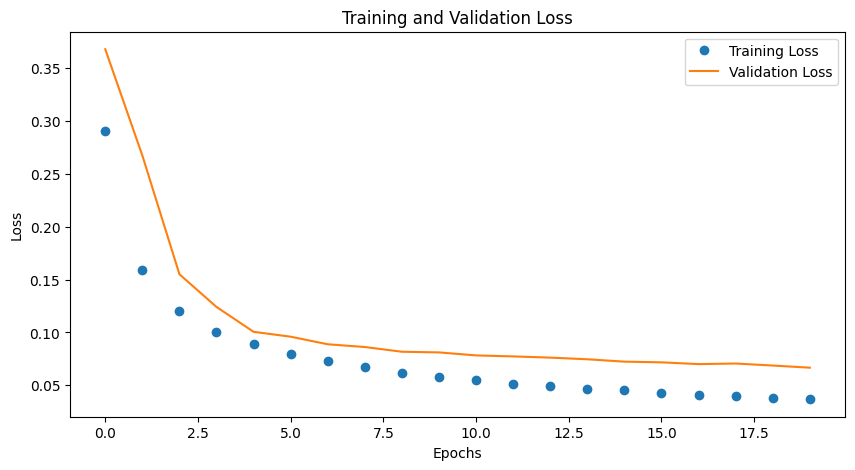

In [29]:

epochs = range(0,len(train_loss_array))

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_array,"o", label='Training Loss')
plt.plot(epochs, validation_loss_array,  label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [15]:
# create test dataset
test_dataset = Dataset(
  "./data/test_set_images", "./data/test_set_images",
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataset_vis = Dataset(
  "./data/test_set_images", "./data/test_set_images",
    classes=CLASSES,
)
test_dataloader = DataLoader(test_dataset)

In [ ]:
n = len(test_dataset)
best_model = torch.load('./data/best_model.pth')

for i in range(1,n+1):

    #n = np.random.choice(len(test_dataset))


    image, gt_mask = test_dataset[i-1]



    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    #pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    pr_mask = (pr_mask.squeeze().cpu().numpy())
    #a = pr_mask[:1]
    #print(a[a<0.5], pr_mask.shape)
    #pr_mask = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    #pr_mask[pr_mask == 0] = -1     # Temporarily replace 0 with a placeholder (-1)
    #pr_mask[pr_mask == 1] = 0      # Replace 1 with 0
    #pr_mask[pr_mask == -1] = 1

    #pr_mask = cv2.resize(pr_mask, (600, 600), interpolation=cv2.INTER_AREA)

    #cv2.imwrite('pred_DeepLabV3/predictions/image_' + '%.3d' % i + '.png', pr_mask)
    plt.imsave('pred_DeepLabV3/predictions/image_' + '%.3d' % i + '.png',pr_mask)
    image = Image.open("pred_DeepLabV3/predictions/image_001.png")
    plt.imshow(image)




In [1]:

submission_filename = 'pred_DeepLabV3/submission.csv'
image_filenames = []
for i in range(1,51):
    image_filename = 'pred_DeepLabV3/predictions/image_' + '%.3d' % i + '.png'
    image_filenames.append(image_filename)
masks_to_submission(submission_filename, *image_filenames)

NameError: ignored

In [78]:
df = pd.read_csv("./pred_DeepLabV3/submission.csv")
df1 = df[df.prediction == 1]
df0 = df[df.prediction == 0]

image = Image.open("pred_DeepLabV3/predictions/image_001.png")

print(len(df1),len(df0))


72200 0


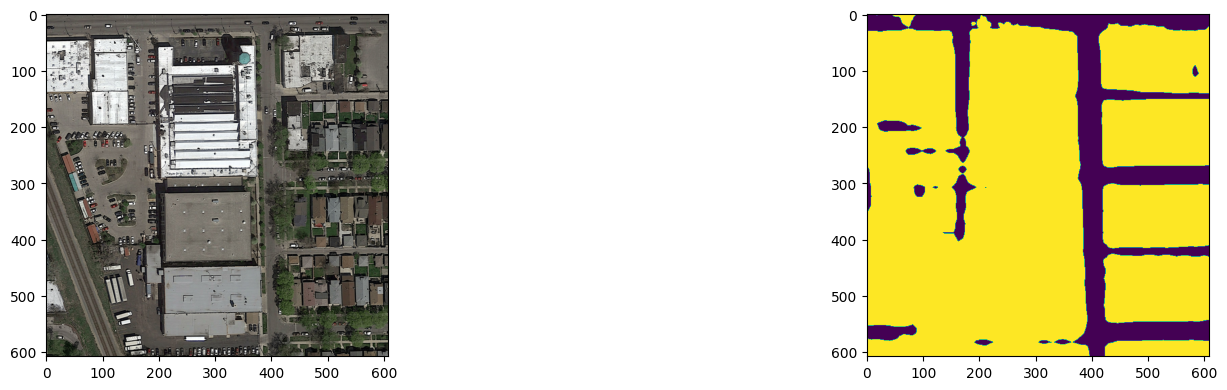

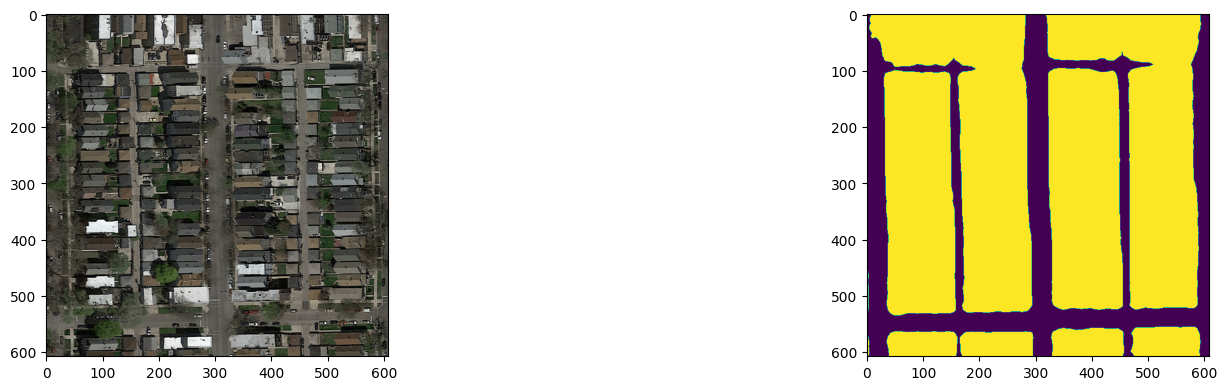

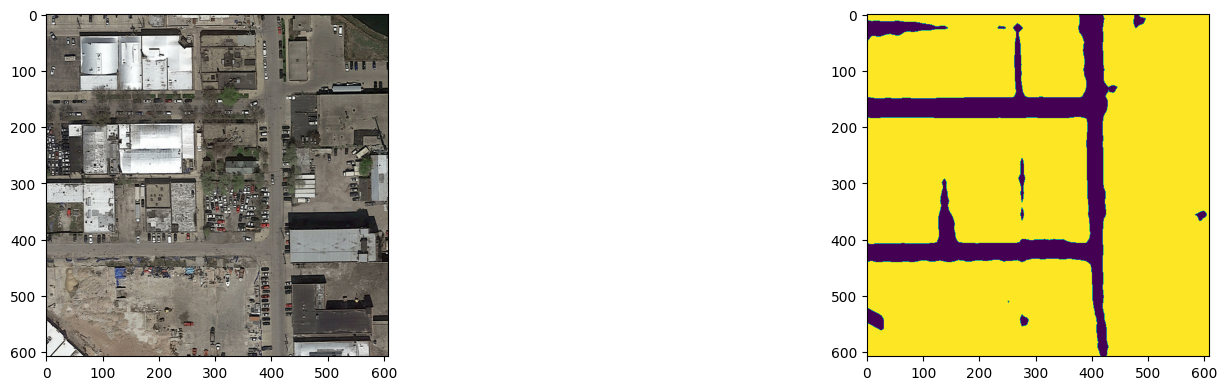

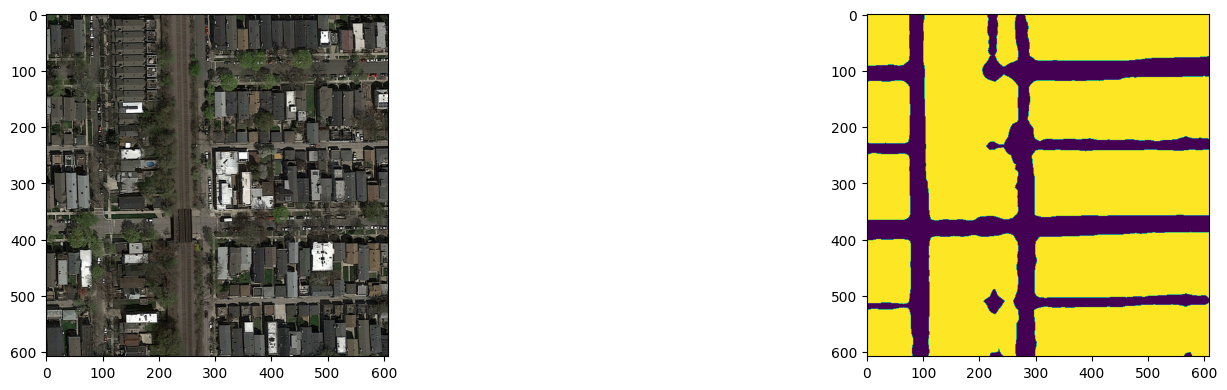

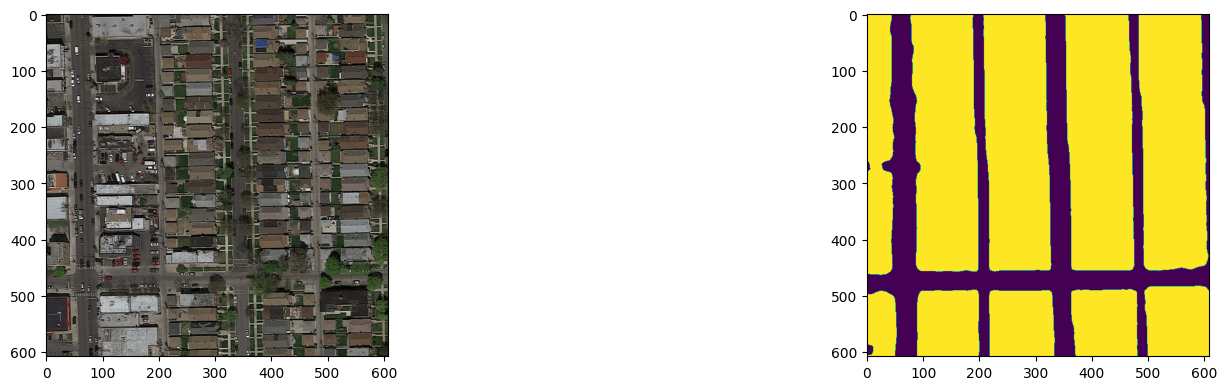

In [40]:



for i in range(5):
    n = np.random.choice(len(test_dataset))

    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]

    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())




    plt.figure(figsize=(15, 5))  # Set the figure size as needed

    # Display img1 in the first subplot
    plt.subplot(1, 3, 1)
    plt.imshow(image_vis)

    #plt.subplot(1, 3, 2)
    #plt.imshow(gt_mask)

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask)






